# Boosted Decision Tree tutorial

## Introduction

**Boosted decision trees** (BDTs) are an example of an *ensemble method* of machine learning. They are based on the principle that an *ensemble of weak learners* (e.g. whose performance is only little better than a guess) can be combined statistically to produce a much stronger learner. Boosting is a general technique applicable to any weak learning method, but in high energy physics it is almost always used in conjunction with *decision trees*, leading to the BDT. In this tutorial we'll go step-by-step through the relevant aspects of BDTs, such that at the end, you can apply them to your own problems. Throughout we will use two pieces of software:
* [SciKitLearn](http://scikit-learn.org/stable/) - a general machine learning framework
* [XGBoost](https://xgboost.readthedocs.io/en/latest/) - a dedicated BDT package that is both high-peformance and also easy to use.

The former is available in Anaconda by default, whereas the second must be installed with

`conda install -c conda-forge xgboost`

To draw the decision trees you need to additionally install graphviz:

`conda install graphviz`

We will use data internally generated by SciKitLearn as well as data from the [Open Data Portal](http://opendata.cern.ch)

Before starting anything else, you need to install [Anaconda](https://anaconda.org). If everything is correctly installed you should be able to run the cell immediately below...

In [1]:
# Import of required packages
import numpy as np
import xgboost as xgb
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib
# Preliminaries ensuring the plots aren't too small
matplotlib.rcParams.update({'font.size': 20})
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

## Motivation
Consider some labelled, 2-dimensional, multi-variate data in two categories, 0 and 1 (coloured purple and yellow):

In [2]:
# Generate data in two dimensions in two classes, namely two spatially separated clusters
samples = 5000
X, y = datasets.make_blobs(n_samples=samples*2, centers=2)
# Split into training and testing samples
X_train = X[0:samples,:]
X_test = X[samples:(samples*2),:]
y_train = y[0:samples]
y_test = y[samples:samples*2]

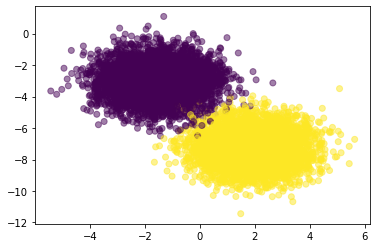

In [3]:
# Plot the data
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.5)
plt.show()

In this case there is no question about how to separate the data - you just draw a line equidistant from the centres of the clusters and the job is done. This can be illustrated by using the simplest ML algorithm possible - a linear (Fisher) discriminant. We train it on the firsat portion of the data produced above, and test it on the second part (note that both parts are displayed together in the plot above). The plot produced below shows the results for the testing (unseen) data - blue indicates that the classifier correctly assigned the category label, red that it got it wrong. 

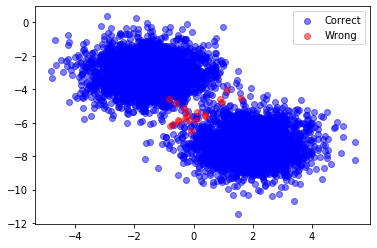

In [4]:
# Set up linear discriminator
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(solver="svd")
# Test on the unseen data and plot the results
y_pred = lda.fit(X_train, y_train).predict(X_test)
plt.scatter(X_test[y_pred==y_test][:,0], X_test[y_pred==y_test][:,1], alpha=0.5, color='blue', label="Correct")
plt.scatter(X_test[y_pred!=y_test][:,0], X_test[y_pred!=y_test][:,1], alpha=0.5, color='red', label="Wrong")
plt.legend()
plt.show()

The linear discriminant has been fully successful, so if the problem looks like the one above, with fully linearly separable data categories, there is no need to use anything more complicated.

For a contrary case, where a linear discriminant is insuffient, consider the following dataset:

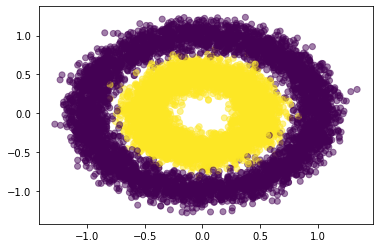

In [5]:
# Generate points distributed into two concentric circles
X, y = datasets.make_circles(n_samples=samples*2, factor=.5, noise=.1)
X_train = X[0:samples,:]
X_test = X[samples:(samples*2),:]
y_train = y[0:samples]
y_test = y[samples:samples*2]
# Plot the data
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.5)
plt.show()

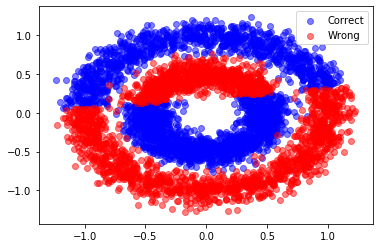

In [6]:
y_pred = lda.fit(X_train, y_train).predict(X_test)
plt.scatter(X_test[y_pred==y_test][:,0], X_test[y_pred==y_test][:,1], alpha=0.5, color='blue', label="Correct")
plt.scatter(X_test[y_pred!=y_test][:,0], X_test[y_pred!=y_test][:,1], alpha=0.5, color='red', label="Wrong")
plt.legend()
plt.show()

Clearly the linear discriminant is not able to handle such a distribution, unless one were to transform it first into polar coordinates. 

## Decision trees

*Decision trees* are a simple means of separating events into classes, or of approximating functions. They work by repeatedly partitioning data into a tree-like structure with the end "leaves" containing (ideally) pure signal and background. In high energy physics terms, they make a sequential series of cuts, but across as many dimensions as are available. 

Decision tree learning proceeds as follows:

1. The training data is partitioned using a rectangular cut in the variable that gives the optimal separation of the signal and background. 
2. Each of the two pieces of data partitioned above will likely still contain a mixture of signal and background, but with less contamination in each piece. So the data can be partitioned again, using a different cut variable, to obtain pieces with even better separation.
3. The procedure can continue as many times as is required to get the requiste separation. This is referred to as the *depth* of the tree, with two sets of cuts being a depth of two. The means by which the algorithm determines whether to continue partitioning to the maximum depth, or to stop, is a hyper-parameter of the model. Likewise, the means by which the partioning is done can also be changed according to requirements.
4. The end result is a *trained decision tree*, which is essentially a list of rectangular cuts. Unseen (but labelled) data is fed into the tree and the same cuts applied. The number of signal and background in each end leaf are then counted up, and the fraction of each can be taken to be the probability that an event ending in a given leaf will be signal or background.
5. New (unlabelled) data is fed into the tree and events ending up in each end leaf are assigned the same probability of being signal or background as acertained in step (4).

See a demonstration in the next cells.

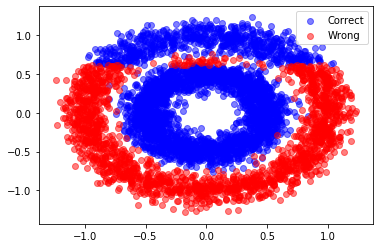

In [7]:
# Setting up a single decision tree
xgbclassifier = xgb.XGBClassifier(
    max_depth=1, # Depth of 1, e.g. a single cut  
    n_estimators=1) # Just one tree
xgbclassifier.fit(X_train, y_train) 
# Evaluate performance and plot
y_pred = xgbclassifier.predict( X_test )
right = (y_pred==y_test)
wrong = (y_pred!=y_test)
plt.scatter(X_test[right][:,0], X_test[right][:,1], alpha=0.5, color='blue', label="Correct")
plt.scatter(X_test[wrong][:,0], X_test[wrong][:,1], alpha=0.5, color='red', label="Wrong")
plt.legend()
plt.show()

A particular strength of decision trees is that they can be inspected internally to visualise how the training has proceeded (e.g. they are a *transparent box*). This is in contrast to many machine learning algorithms, whose internal values can't easily be interpreted in terms of the input and output. 

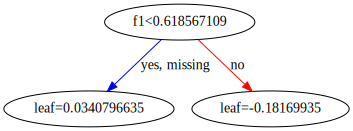

In [8]:
# Visualise the decision tree
xgb.to_graphviz(xgbclassifier, num_trees=0)

**Try it out:** try varying the depth parameter until most of the points are correctly classified, and inspect the tree each time.

Note that decision trees can also be used for *regression* (supervised machine learning for which the training targets are continuous real-valued numbers rather than categorical variables). See the example in the next cell.

**Try it out:** observe how the fit changes as the depth is increased or decreased. Note the effect that the random noise has on the fit when the depth is increased.

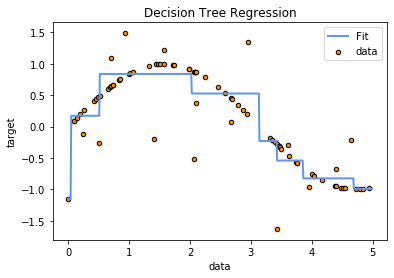

In [9]:
# Demonstration of decision tree regression

# Create dataset
rng = np.random.RandomState(1)
X_reg_train = np.sort(5 * rng.rand(80, 1), axis=0)
y_reg_train = np.sin(X_reg_train).ravel()
y_reg_train[::5] += 3 * (0.5 - rng.rand(16)) # Random noise


# Fit regression model
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=3)
regressor.fit(X_reg_train,y_reg_train)
X_reg_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_reg_test = regressor.predict(X_reg_test)

# Plot the results
plt.figure()
plt.scatter(X_reg_train, y_reg_train, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_reg_test, y_reg_test, color="cornflowerblue",
         label="Fit", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

## Boosted Decision Trees

You will find that, with sufficient depth, the classifier is able to correctly assign almost all points. However, most data is significantly more complicated than the above example. Decision trees have several serious deficiences:
* Susceptible to learn from random fluctuations (over-training) - they do not generalise well
* Unstable and fragile: small variations in the training data can lead to completely different trees being formed 
* Unbalanced classes may lead to skewed trees

By combining the outputs of many trees, these problems can be at least partially overcome. 

**Try it out**: in the classification example above, set the maximum depth back to 2, and now increase the number of trees used. How many are needed to correctly identify most points?

### How boosting works

In all cases we seek an ensemble $T$ made up of $M$ trees that minimises the value of some objective function $J$ on the training data $\textbf{x}$. Each new tree $h$ tries to correct the mistakes of its predecessors:

$T(\textbf{x})=\sum^M_{i=1}\alpha_i h_i(\textbf{x})$

So we have for the first tree:
$T_0(\textbf{x}) = 0$

and for the $m$th tree:
$T_m(\textbf{x}) = T_{m-1}(\textbf{x})+ \underset{h_m \in H}{\arg\min}\sum^n_{i=1}J\left(y_i,T_{m-1}(x_i)+h_m(\textbf{x}_i)\right)$

where the sum is over events. Don't forget that **x** is a multidimensional quantity, which is why it is in bold. The expression above is essentially saying: to the existing ensemble, add a new tree $h_m$ from the total set of available trees $H$ that minimises the objective $J$ evaluated over the training data.

All decision tree boosting techniques are based on the above - they differ in how the new trees are appended to the existing ensemble.

### Additive boosting

In *additive boosting*, when building the ensemble of decision trees, previously misclassified events are upweighted for the next tree. This means that each new tree is forced to focus on the events that are difficult to separate. It works as follows:

Let the initial sample weights be:
$\{w_{1,1}...,w_{N,1}\} = \{\frac{1}{N},...,\frac{1}{N}\}$

such that:
$\textbf{x}=\{w_1\textbf{x}_1,...,w_N\textbf{x}_N\}; \textbf{y}=\{y_1,...,y_N\}$

with the training targets $y$ being
$y\in\{-1,1\}$

Then to build an ensemble $T$ of $M$ decision trees -

for $m$ in $1,...,M$:

* $h_m(\textbf{x})$ - $m$th tree built as per recipe on previous slides
* $\epsilon_m = \sum^{n}_{i=0}w_{i,t} : h_m(x_i)\ne y_i$ - the *error*, which is the sum of weights for misclassified events
* Now append the $m$th tree to the ensemble - $T(\textbf{x}) = T(\textbf{x})+\alpha_m h_m(\textbf{x})$ where $\alpha_m=\frac{1}{2}\ln\left(\frac{1-\epsilon_m}{\epsilon_m}\right)$
* Update the weights (and renormalise) using a standard error function: $w_{i,m+1}=w_{i,m}e^{-y_i\alpha_m h_m(x_i)}$ 

Following this procedure the ensemble $T$ is used to classify new data.

### Gradient boosting

In *gradient boosting* the weights are updated such that the gradient of the objective function $J$ points in a downwards direction. As such, it is an implementation of *gradient descent*. Consider a BDT which has reached perfection in its training:

$T_{m+1}(\textbf{x}) = T_m(\textbf{x})+h(\textbf{x}) = \textbf{y}$

such that

$h(\textbf{x}) = \textbf{y}-T_m(\textbf{x})$

These *residuals* are the gradients with respect to the overall ensemble $T$ of the objective function $J$, and gradient boosting involves setting the weights such that the gradients "point downhill" at each iteration. The algorithm proceeds as follows

for $m$ in $1,...,M$:

* Calculate the gradients for each event: $r_{i,m} = - \left[\frac{\partial J(y_i,T_{m-1}(\textbf{x}_i))}{\partial T_{m-1}(\textbf{x}_i)}\right] \textrm{for } i=0,...,n$
* Train the new tree $h_m$ using the gradients $r_{i,m}$ as the event weights
* Find $\gamma_m$ such that $\gamma_m = \underset{\gamma}{\arg\min}\sum^n_{i=1}J\left(y_i,T_{m-1}(\textbf{x}_i)+\gamma h_m(\textbf{x}_i)\right)$
* Update $T$: $T_m(\textbf{x}) = T_{m-1}(\textbf{x})+\gamma_mh_m(\textbf{x})$

Following this procedure the ensemble $T$ is used to classify new data.

XGBoost, used throughout this worksheet, is a highly efficient, robust and scalable implementation of gradient boosting

## Using the HiggsML dataset

In this section we will apply XGBoost to a "real" dataset from the OpenData Portal - the [HiggsML dataset](http://opendata.cern.ch/record/328). This is simulated data that was used for the HiggsML Challenge some years ago (and in fact, XGBoost won the challenge). The dataset is in plain text format and consists of columns of physics quantities plus a label indicating whether the event (row) is signal or background. The signal is the challenging H$\to\tau\tau$ decay. 

We will first use Pandas to extract the information from the plain text file, and then apply XGBoost to it. We will study some of the BDT properties along the way.

First take a look at the documentation accompanying the HiggsML challenge. In particular pay particular attention to the list of variables. Note two things in particular:
* Apart from the columns defining event weights and other supplementary information, the variable names begin either with "PRI" or "DER". This stands for "primary" (variables directly representing a reconstructed object like a track or jet) and "derived" (variables calculated from reconstructed objects, that impose additional knowledge of physics
* Some of the variables can only be defined when certain reconstructed objects exist: for instance, if there are no jets then `PRI_jet_leading_pt` cannot be defined since there is no leading jet. In the HiggsML dataset such entries are set to `-999.9` to indicate that the variable doesn't exist for this event. Such undefined variables are very troublesome for many machine learning algorithms and must be preprocessed away beforehand - but they present no problem for BDTs. All you have to do is tell the algorithm that any value with `-999.0` should be ignored, and if it needs to cut on these variables, it just assigns the events where the variable is missing to one leaf or the other, according to some criteria.

### Using Pandas to extract the data

**Try it out**: download the comma-separated-values data file from the above link, extract (uncompress) it and place it in the same directory as this notebook (some operating systems, e.g. macOS, may do the extraction automatically on download). Then, import the data with the columnnar-data handling package [Pandas](https://pandas.pydata.org), which ships with Anaconda. Plot some (maybe all) of the different values. Then create the data samples.

In [10]:
# Import the Pandas package
import pandas as pd
# Import the HiggsML dataset
df = pd.read_csv("atlas-higgs-challenge-2014-v2.csv") #,usecols=variables)
df_label = df.Label 
# Turn the signal and background labels into 0s and 1s
df_label = df_label.replace('s',1) 
df_label = df_label.replace('b',0)
# Take a look at the first five rows (events) of the resulting Pandas dataframe
df.head()

FileNotFoundError: [Errno 2] File b'atlas-higgs-challenge-2014-v2.csv' does not exist: b'atlas-higgs-challenge-2014-v2.csv'

In [11]:
# Get the full list of variable names
print(df.dtypes)

NameError: name 'df' is not defined

In [ ]:
# Inspect some (or all...) of the columns using the names printed in the above cell
variable = 'DER_mass_transverse_met_lep' 
hist = df[variable].hist(bins=100)
hist.set_xlabel('DER_mass_transverse_met_lep')
plt.show()

In [ ]:
# Set the size of each portion of data
test_size = 50000
# Convert to numpy arrays (input)
# Separate into data, weights, target
Y = np.array(df_label)
X = np.array(df.drop(["Label","Weight","KaggleSet","KaggleWeight","EventId"],axis=1)) # Remove variables that should NOT be trained on
W = np.array(df.Weight) * float(test_size) / len(Y) # Ensure the weights are scaled to the size of the test portion

In [ ]:
# Build training, validation & evaluation samples (test_size events for each of signal and background per sample)
size = test_size
X_train = np.concatenate((X[Y==0][0:size],X[Y==1][0:size]), axis=0)
w_train = np.concatenate((W[Y==0][0:size],W[Y==1][0:size]), axis=0)
y_train = np.concatenate((Y[Y==0][0:size],Y[Y==1][0:size]), axis=0)
X_valid = np.concatenate((X[Y==0][size:size*2],X[Y==1][size:size*2]), axis=0)
y_valid = np.concatenate((Y[Y==0][size:size*2],Y[Y==1][size:size*2]), axis=0)
X_eval = np.concatenate((X[Y==0][size*2:size*3],X[Y==1][size*2:size*3]), axis=0)
y_eval = np.concatenate((Y[Y==0][size*2:size*3],Y[Y==1][size*2:size*3]), axis=0)
# Get the sums of the weights for signal and background events 
sum_wsig = sum( w_train[i] for i in range(len(y_train)) if y_train[i] == 1.0  )
sum_wbkg = sum( w_train[i] for i in range(len(y_train)) if y_train[i] == 0.0  )

### Building and running the BDT

Next we create the BDT and train it on the training sample. Note that this code is similar to the examples above with the trivial 2D dataset, but exposes a number of additional hyperparameters which are not explicitly set in the above examples (e.g. the defaults are used in the trivial examples).

The additional hyperparameters are
* `learning_rate`: this is a constant factor that is applied at the boosting step. If it is less than one it has the effect of reducing the capacity of the overall ensemble to adapt to the data - in other words, it is a means of *regularisation*. This parameter must be tuned to each particular case (see the exercise in the next section).
* `n_jobs`: this can be used to run in multi-threaded mode, with the number being the number of concurrent threads. Generally it makes sense to set it to the number of CPU cores in your computer.
* `scale_pos_weight`: indicates the ratio of the sums of weights of signal and background events. Used to counter the skewing effects of an unbalanced sample. Note that the outputs of the BDT can't be interpreted as probabilities once this setting differs from the default of 1.
* `objective`: the form of the objective function *J* that is differentiated to obtain the gradients as described above
* `missing`: indicates the placeholder value for missing entries, so that the BDT software doesn't try to cut on such values

**Try it out**: execute the cells below to set up and train the BDT. 

In [ ]:
# Set up the BDT classifier
xgbclassifier = xgb.XGBClassifier(
    max_depth=3, 
    n_estimators=120,
    learning_rate=0.1,
    n_jobs=4,
    scale_pos_weight=sum_wbkg/sum_wsig,
    objective='binary:logistic',
    missing=-999.0) 
xgbclassifier.fit(X_train,y_train,w_train) 

In [ ]:
# Test the BDT performance using the validation dataset
y_pred = xgbclassifier.predict( X_valid ) # The actual signal/background predictions. Note that we don't actually use them
y_pred_prob = xgbclassifier.predict_proba( X_valid ) # The BDT outputs for each event

Now we are in a position to plot the BDT outputs on the validation dataset for signal and background, and the resulting response-operator (ROC) curves, using the BDT outputs obtained in the cell above. The more separated the background and signal distributions, the better the model is performing.

In [ ]:
#  histogram of the BDT outputs
n, bins, patches = plt.hist(y_pred_prob[:,1][y_valid==0], 200, normed=0, facecolor='blue', alpha=0.2,label="Background")
n, bins, patches = plt.hist(y_pred_prob[:,1][y_valid==1], 200, normed=0, facecolor='red', alpha=0.2, label="Signal")

plt.xlabel('XGBoost output')
plt.ylabel('Events')
plt.title('XGBoost output, HiggsML dataset, validation data')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(y_valid,y_pred_prob[:,1], pos_label=1)
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for xgBoost on HiggsML dataset')
plt.legend(loc="lower right")
plt.show()

**Try it out**: re-run the BDT a few times with different numbers of boosting cycles, different tree depths and different values for the learning rate, and inspect the outputs and the resulting ROC. You will observe:
* the more trees are used, the smoother the output distribution of the BDT. This is advantageous since physics analyses often fit to the BDT output shapes, and smoother distributions are clearly preferred.
* increasing the number of trees leads to improved separation power to some limit, after which saturation is reached and no further improvements can be obtained
* aside of the requirement to have smooth output, there is no obvious answer as to what the correct strategy should be in terms of getting the best balance between the number of trees, their maximum depth, and the learning rate. This has to be evaluated on a case by case basis. See the next section for more details on hyperparameter tuning.

One particularly attractive feature of BDTs is the ease in which variables can be ranked in importance. There are a number of ways of measuring the variable importance, the most common of which is the number of times the variable is used to slice the data. XGBoost offers several means of calculating this. Even better, it has a convenient build-in tool for graphically plotting the importances. 

In [ ]:
# Plot variable importance
xgb.plot_importance(xgbclassifier)
fig_size[0] = 15
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size
plt.show()

It is still possible to inspect graphically the cut values for individual trees in the ensemble. The tree must be specified via an index number as shown below

In [ ]:
# Plot the 2nd decision tree in the ensemble
xgb.to_graphviz(xgbclassifier, num_trees=1)

## BDT Hyperparameter tuning

In this section we look at more detail at the hyperparameters of the BDT and then set up a cross validation scheme to optimise them. The full list of hyperparameters can be found in the [relevant section](https://xgboost.readthedocs.io/en/latest/parameter.html) of the XGBoost manual. 

In this part we will focus on the following hyperparameters:
* Number of trees: `n_estimators` 
* Maximum tree depth: `max_depth` 
* Learning rate: `learning_rate` 
* Minimum change in objective for which an additional leaf split is allowed: `gamma` 
* Minimum sum of weights allowed in a newly partitioned leaf: `min_child_weight`
* L2 regularisation term on weights: `lambda`
* L1 regularisation term on weights: `alpha`
* Objective function used to evaluate the ensemble: `objective`

### Validation curves

In the examples above you were asked to play with a few of the values to see how the performance changed. In reality one never sets the hyperparameters this way - they need to be methodically varied until the best performance is attained. We will look at this shortly. First, we can make plots known as *validation curves* which hold all of the hyperparameters fixed apart from one, which is varied across its range. We can then see how the algorithm performs when tested both on its training data and validation data, enabling the analyst to gain some sense of the impact of the hyperparameters on the *bias-variance tradeoff*. 

SciKitLearn offers a built-in function for producing the validation curves, as demonstrated below.

**Try it out**: run the example below with the different hyperparameters. This should give you some idea of whether increasing each hyperparameter makes the model more *conservative*, that is, more biased but less inclined to over-train due to excessive complexity, or otherwise.

In [ ]:
# Set up the ranges of each hyperparameter
n_estimators = [1,5,10,50,100,200]
max_depth = [1,2,4,6,8,10,20,50]
learning_rate = [0.1,0.2,0.4,0.6,0.8,1.0]
gamma = [0,1,2,4,6,8,10]
min_child_weight = [0,1,2,4,6,8,10]
reg_lambda = [0,1,2,4,6,8,10]
reg_alpha = [0,1,2,4,6,8,10]

In [ ]:
# Set up the validation curves (may take some time since training must be re-run for each value)
from sklearn.model_selection import validation_curve
param_range = n_estimators
param_name = "n_estimators"
scoring = "roc_auc"
train_scores, valid_scores = validation_curve(xgbclassifier, 
                                              X_train, 
                                              y_train, 
                                              param_name=param_name, 
                                              param_range=param_range, 
                                              cv=3, 
                                              scoring=scoring, 
                                              n_jobs=4, 
                                              verbose=0)

In [ ]:
# Plot the validation curves
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

fig_size[0] = 15
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

plt.title("Validation Curve for BDT")
plt.xlabel(param_name)
plt.ylabel(scoring)
plt.ylim(0.6, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, valid_scores_mean, label="Validation",
             color="navy", lw=lw)
plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

A few points need to be clarified here.

Firstly, the score being used to make the plot is the area under the ROC curve, as demonstrated several cells above. This is not the only measure of the performance - a list of those implemented in SciKitLearn can be found [here](http://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values). **Try it out**: use some of the other measures listed on the SKL page and see how it affects the validation curves. The correct measure to use is a matter of debate, and a thorough study should involve looking at more than one measure.

Secondly, note that the method making the data for the plot only takes portion of data that we previously assinged to training in the previous section. This is because it has to re-train for each hyperparmeter setting and it partitions the data automatically, e.g. it takes part of it for training, and part for validation. 

Thirdly, note that some of the variables may not have much or any affect on the performance. This depends on the nature of the dataset so don't be too surprised.

Finally, you may be wondering what the `cv` argument is about. We'll come to that now...

### Hyperparameter tuning using cross validation

The above way of studying the hyperparameters is fine for getting a qualitative idea of how the different parameters affect the model, but they are insufficient for rigorous tuning. For this the different parameters needs to be modified methodically and the model tested for each combination of parameters. The simplest way of doing this is via an *exhaustive grid search* where every possible combination of the provided hyperparameter values is tested. This can be very slow if the training time is non-negligible. Worse, if many of the variables have little impact on the overall performance, most of this time is wasted trying out pointless combinations. A better approach is therefore a *randomized search*. Here the test values are picked at random from a range selected by the user according to some  distribution that can also be chosen. The tests are then run a given number of times. The advantage of this approach is that the user can decide how long they can afford to wait, and then select the number of trials accordingly. Additionally variables that have no impact on the performance don't add needlessly to the time taken. The obvious downside is that not all values are tried and so the finally selected set of parameters may not be optimal. Usually it will be good enough, though, as long as enough trials are run. Other techniques exist as well - see the relevant [SciKitLearn](http://scikit-learn.org/stable/modules/grid_search.html) documentation. In this example we will use a randomised search.

The other issue is that, even with separated training and validation samples, the end result will still be biased because the hyperparameter tuning is a kind of second-order training, and thus the validation sample becomes a weak training sample. The way around this is *cross validation* where the training and validation datasets are merged into one, and for each cycle of training and validation, the events are shuffled somehow such that each cycle sees different events in the training and testing. This also helps if the total number of events is limited - with cross validation you need only two partioned samples - one for the training+validation, and one for the final performance evaluation.

The usual means of doing cross validation is called *k-fold*: the training+validation sample is split into *k* parts. *k-1* parts are used for the training, and the final *k-th* part is used for the validation. Other techniques also exist: see the relevant section of the [SciKitLearn](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) documentation.

SciKitLearn offers an automatic cross validation mechanism, which is demonstrated below in full.

In [ ]:
# Combine the training and validation sets into one


X_cv = np.concatenate((X_train,X_valid),axis=0)
y_cv = np.concatenate((y_train,y_valid),axis=0)
# Pull in the batch of weights corresponding to X_valid, and combine with w_train
w_next = np.concatenate((W[Y==0][size:size*2],W[Y==1][size:size*2]), axis=0)
w_cv = np.concatenate((w_train,w_next),axis=0)
# Recalculate the weight ratio
sum_wsig = sum( w_cv[i] for i in range(len(y_cv)) if y_cv[i] == 1.0  )
sum_wbkg = sum( w_cv[i] for i in range(len(y_cv)) if y_cv[i] == 0.0  )


# Redefine the XGBoost classifier
xgbclassifier = xgb.XGBClassifier(
    max_depth=3, 
    n_estimators=120,
    learning_rate=0.1,
    n_jobs=1,
    scale_pos_weight=sum_wbkg/sum_wsig,
    objective='binary:logistic',
    missing=-999.0) 

In [ ]:
# Set up the cross validation machinery
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV

# define the ranges of variables to sample from
param_dist = {"n_estimators": sp_randint(1, 200),
              "max_depth": sp_randint(1,20),
              "learning_rate": sp_uniform(0.1,1.0),
              "gamma": sp_uniform(0,10),
              "min_child_weight": sp_uniform(0,10),
              "reg_lambda": sp_uniform(0,10),
              "reg_alpha": sp_uniform(0,10)
             }

# run random search
n_iter_search = 50
random_search = RandomizedSearchCV(xgbclassifier, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search,
                                   verbose=2,
                                   n_jobs=4,
                                   cv=3,
                                   scoring='roc_auc')
random_search.fit(X_cv, y_cv, sample_weight=w_cv)

In [ ]:
def report(results, n_top=2):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report(random_search.cv_results_)

As you will see, the algorithm tried 10 different combinations of randomly chosen hyperparameters. Each one was fitted three times, according to the request for 3-fold cross validation. This led to 30 separate fits (done in batches of four, one per CPU) and finally a report with the best three results. You'll see that this is a slow process, so the best way to proceed is to be guided by the validation curves as to where the best regions are for each variables (and indeed, whether it is worth tuning a variable away from its default at all), narrow down the search range and then fit. There are also much more sophisticated means of homing in on the best parameters, e.g. Bayesian optimisation.

In principle one can now select the hyperparameters from the best job above and use these to make a final performance assessment on the **evaluation sample**, which you'll observe has not been used so far:

In [ ]:
# Recall the best result
bestHyperParameters = random_search.best_params_
#bestHyperParameters = np.flatnonzero(results['rank_test_score'] == 1)[0]
# Set up the and train the classifier with the new parameters
xgbclassifier = xgb.XGBClassifier(
    max_depth=bestHyperParameters['max_depth'], 
    n_estimators=bestHyperParameters['n_estimators'],
    learning_rate=bestHyperParameters['learning_rate'],
    gamma=bestHyperParameters['gamma'],
    min_child_weight=bestHyperParameters['min_child_weight'],
    reg_alpha=bestHyperParameters['reg_alpha'],
    reg_lambda=bestHyperParameters['reg_lambda'],
    n_jobs=4,
    scale_pos_weight=sum_wbkg/sum_wsig,
    objective='binary:logistic',
    missing=-999.0)
xgbclassifier.fit(X_cv,y_cv,w_cv) 

In [ ]:
# Test the BDT performance using the evaluation dataset
y_pred_prob = xgbclassifier.predict_proba( X_eval ) # The BDT outputs for each event

#  histogram of the BDT outputs
n, bins, patches = plt.hist(y_pred_prob[:,1][y_eval==0], 200, normed=0, facecolor='blue', alpha=0.2,label="Background")
n, bins, patches = plt.hist(y_pred_prob[:,1][y_eval==1], 200, normed=0, facecolor='red', alpha=0.2, label="Signal")

plt.xlabel('XGBoost output')
plt.ylabel('Events')
plt.title('XGBoost output, HiggsML dataset, evaluation data')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(y_eval,y_pred_prob[:,1], pos_label=1)
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for xgBoost on HiggsML dataset, evaluation data')
plt.legend(loc="lower right")
plt.show()

## Ideas for next steps

Now that you have a bit of experience with BDTs, you might like to try some other exercises:
* study the behaviour of other objective functions
* compare results obtained from different performance measures
* try using early stopping
* try other tree building algorithms
* try varying the leaf splitting criteria
* try varying the relative quantities of signal/background in the training to see how this affects the performance
* use your own datasets, others from the open data portal or different internally generated shapes
* try other hyperparameter tuning schemes

Can you do better than 0.89AUC for the Higgs dataset?